<a href="https://colab.research.google.com/github/Narusi/My-Projects/blob/master/IncomePortfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Necesasary libraries

In [0]:
!pip install yfinance

In [0]:
import pandas as pd
import numpy as np
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sn

import requests
from bs4 import BeautifulSoup

import statsmodels.api as sm

# Current portfolio

In [0]:
cport = {
    'O':[['2020-03-31',1.0,51.96]],
    'EVR':[['2020-04-17',0.19694,54.99]],
    'LTC':[['2020-04-29',0.69723,37.44]],
    'ITUB':[['2020-04-29',5.0,4.41],['2020-05-11',4.0,3.89]],
    'ARR':[['2020-04-29',4.0,9.35],['2020-05-11',-4,7.51]],
    'V':[['2020-05-11',0.07067522,183.94]]
    }

In [0]:
portAssets = pd.Series(cport).index.drop_duplicates().to_list()

cportDF = pd.DataFrame(columns=portAssets)
cportPrices = yf.download(portAssets)['Close'].fillna(method='ffill').dropna()
allocTS = pd.DataFrame(index=cportPrices.index, columns=portAssets).fillna(0.0)

for a in portAssets:
    pos = 0.0
    w = np.zeros(len(cport[a]))
    ret = 0.0
    for i in range(len(cport[a])):
        pos += cport[a][i][1]
        allocTS.loc[cport[a][i][0],a] = cport[a][i][1]
    
    for i in range(len(cport[a])):
        if pos == 0.0:
            w[i] = 0.0
        else:
            w[i] = cport[a][i][1] / pos
        ret += (cportPrices.iloc[-1][a]/cport[a][i][2]-1) * w[i]

    cportDF.loc['Position',a] = pos
    cportDF.loc['Amount',a] = cportPrices.iloc[-1][a] * pos
    cportDF.loc['Return',a] = ret
cportDF.loc['Weight'] = cportDF.loc['Amount'].div(cportDF.loc['Amount'].sum())

[*********************100%***********************]  6 of 6 completed


Portfolio return: -1.83%


,O,EVR,LTC,ITUB,ARR,V
Position,1,0.19694,0.69723,9,0,0.0706752
Amount,51.69,10.2428,24.8702,36.495,0,13.4276
Return,-0.00519633,-0.0541917,-0.0472757,-0.0258699,0,0.0328912
Weight,0.378056,0.0749154,0.181899,0.266921,0,0.0982083


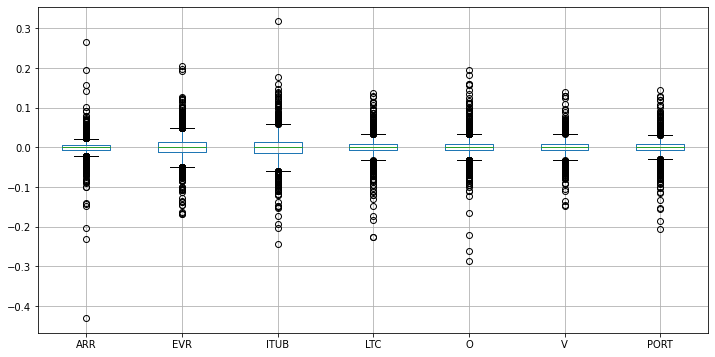

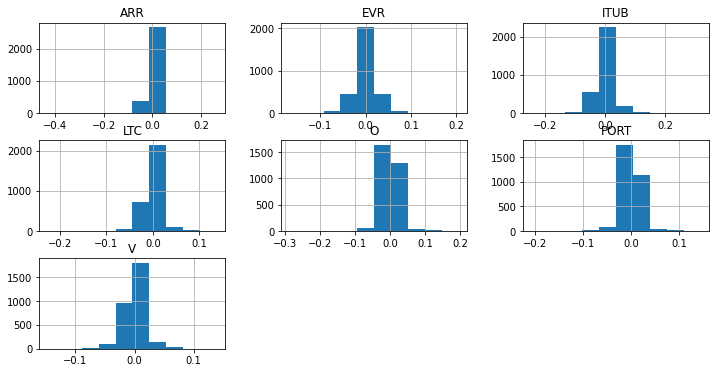

In [0]:
print('Portfolio return: {}%'.format(round(100*np.dot(cportDF.loc['Weight'], 
                                                      cportDF.loc['Return']),2)))

cRet = np.log(cportPrices/cportPrices.shift(1))
cRet['PORT'] = cRet.mul(cportDF.loc['Weight',cRet.columns]).sum(axis=1)

cRet.boxplot(figsize=(12,6))
cRet.hist(figsize=(12,6))

portAssets = cportDF.loc['Weight']
portAssets = portAssets[portAssets>0.0].index.to_list()

cportDF

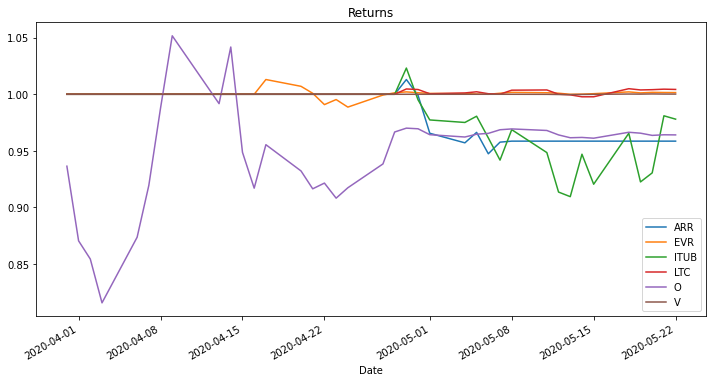

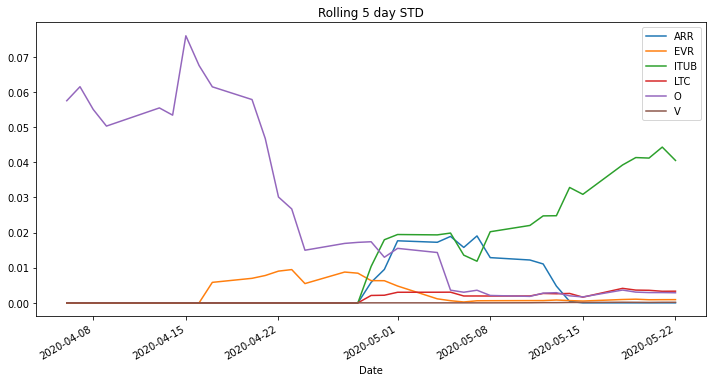

,ARR,EVR,ITUB,LTC,O,V
Date,,,,,,
2020-05-18,0.0,0.001580,0.048859,0.007146,0.005453,0.000271
2020-05-19,-0.0,-0.000887,-0.044493,-0.001086,-0.000829,-0.000068
2020-05-20,0.0,0.000488,0.008663,0.000233,-0.002016,0.000151
2020-05-21,-0.0,-0.000123,0.054185,0.000446,0.000548,-0.000109
2020-05-22,-0.0,-0.000079,-0.003031,-0.000231,-0.000106,-0.000021


In [0]:
allocations = allocTS.cumsum()
allocations = allocations.div(allocations.sum(axis=1), axis=0)
allocations = allocations.mul(cRet.drop('PORT',axis=1)).dropna()

allocations.add(1).cumprod().plot(figsize=(12,6),title='Returns')
plt.show()

allocations.rolling(5).std().plot(figsize=(12,6),title='Rolling 5 day STD')
plt.show()

allocations.tail()

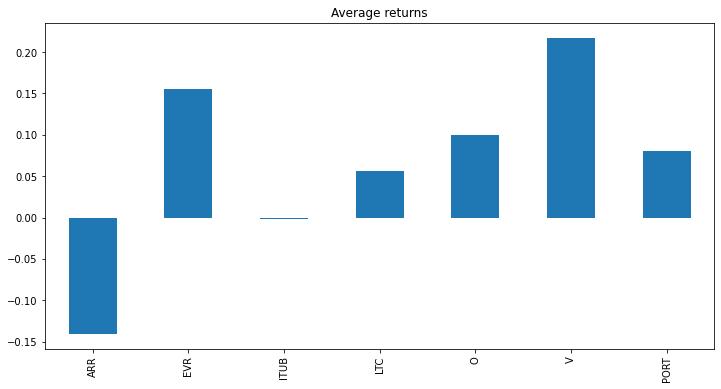

In [0]:
cRet.rolling(252).sum().mean().plot(kind='bar', figsize=(12,6), title='Average returns')
plt.show()

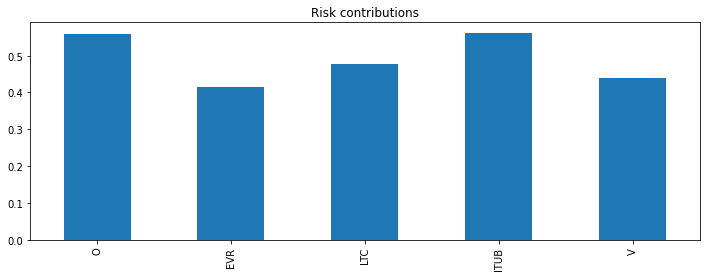

In [0]:
w = cportDF.loc['Weight']
riskContr = pd.DataFrame(np.dot(np.matrix(w), cRet.drop('PORT', axis=1).corr()).T, index=cportDF.columns)
actPos = cportDF.loc['Weight'][cportDF.loc['Weight'] > 0.0].index

riskContr.loc[actPos].plot(kind='bar', 
                           title='Risk contributions', 
                           legend=False, figsize=(12,4))
plt.show()

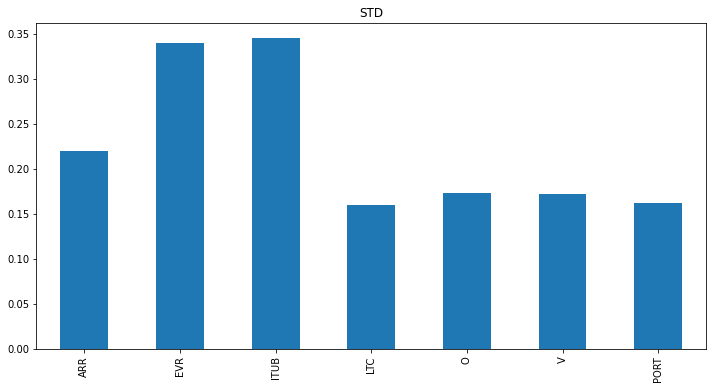

In [0]:
cRet.rolling(252).sum().std().plot(kind='bar', figsize=(12,6), title='STD')
plt.show()

# Investment universe

### Functions

In [0]:
def readHoldings(fund):
    fundPage = requests.get('https://etfdb.com/etf/' + fund + '/#holdings')
    soup = BeautifulSoup(fundPage.content, 'html.parser')

    tickers = []
    for a in soup.find_all('tbody')[2].find_all('a'):
        tickers.append(a.text)
    return tickers

def divPayers():
    assets = pd.read_html('https://en.wikipedia.org/wiki/S%26P_500_Dividend_Aristocrats')[2]['Ticker Symbol'].to_list()
    page = requests.get('https://moneyinvestexpert.com/dividend-kings-list')
    soup = BeautifulSoup(page.content, 'html.parser')

    for a in soup.find('div', {'id':'content'}).find_all('li'):
        if a.text.find('(') != -1:
            assets.append(a.text.split('(')[1].split(')')[0])
    assets = pd.Series(assets).drop_duplicates().to_list()
    return assets

def scrapeWatchlist(wPath = ''):
    page = requests.get(wPath)
    soup = BeautifulSoup(page.content, 'html.parser')

    assets = []
    for a in soup.find_all('a'):
        qq = str(a.get('href')).split('/')
        if qq[1] == 'quote':
            if not '?' in qq[2]:
                assets.append(qq[2])
    return assets

def expectedReturn(p, a, verbose=False, output='prob'):
    p = pd.DataFrame(p.fillna(method='ffill').dropna())

    #sigma = p.pct_change().std()

    if verbose: print('Creating moving averages');
    p['SMA200'] = p[a].rolling(200).mean().fillna(method='bfill')
    p['SMA100'] = p[a].rolling(100).mean().fillna(method='bfill')
    p['SMA50'] = p[a].rolling(50).mean().fillna(method='bfill')

    p['R50'] = p['SMA50'].pct_change(5).fillna(0.0)
    p['R100'] = p['SMA100'].pct_change(10).fillna(0.0)
    p['R200'] = p['SMA200'].pct_change(20).fillna(0.0)

    p['D50'] = 0
    p.loc[p['R50']<-0.01,'D50'] = -1
    p.loc[p['R50']>0.01,'D50'] = 1

    #p['D100'] = 0
    #p.loc[p['R100']<-0.02,'D100'] = -1
    #p.loc[p['R100']>0.02, 'D100'] = 1

    #p['D200'] = 0
    #p.loc[p['R200']<-0.04,'D200'] = -1
    #p.loc[p['R200']>0.04, 'D200'] = 1

    p['SMA50+10'] = p['SMA50'].mul(1.10)
    p['SMA50-10'] = p['SMA50'].mul(0.90)
    p['SMA100+10'] = p['SMA100'].mul(1.10)
    p['SMA100-10'] = p['SMA100'].mul(0.90)    
    p['SMA200+10'] = p['SMA200'].mul(1.10)
    p['SMA200-10'] = p['SMA200'].mul(0.90)

    if verbose: print('Creating boolenial bands');
    p['BOOL+'] = p[a].rolling(99).mean().fillna(method='bfill').add(p[a].rolling(200).std().mul(2)).fillna(method='bfill')
    p['BOOL-'] = p[a].rolling(99).mean().fillna(method='bfill').sub(p[a].rolling(200).std().mul(2)).fillna(method='bfill')

    if verbose:
        p['D50'] = p['D50']*100
        p.iloc[-3*252:].plot(figsize=(12,6))
        plt.show();
        p['D50'] = p['D50']/100

    if verbose: print('Creating boolenial signals');
    p['BOOL+S'] = 0
    p.loc[np.logical_and(p[a]>p['BOOL-'], p[a].rolling(5).min()<p['BOOL-'].rolling(5).min()), 'BOOL+S'] = 1
    p.loc[np.logical_and(p[a]<p['BOOL+'], p[a].rolling(5).mean()<p['BOOL+'].rolling(5).mean()), 'BOOL+S'] = -1

    if verbose: print('Creating moving average signals');
    p['SMA+S'] = 0
    p.loc[np.logical_and(p['SMA100']<p['SMA50'], p['SMA100'].rolling(5).min()>p['SMA50'].rolling(5).min()), 'SMA+S'] += 1
    p.loc[np.logical_and(p['SMA200']<p['SMA50'], p['SMA200'].rolling(5).min()>p['SMA50'].rolling(5).min()), 'SMA+S'] += 1
    p.loc[np.logical_and(p['SMA200']>p['SMA100'], p['SMA200'].rolling(5).min()>p['SMA100'].rolling(5).min()), 'SMA+S'] += 1
    p.loc[np.logical_and(p['SMA50']<p['SMA100'], p['SMA50'].rolling(5).mean()>p['SMA100'].rolling(5).mean()), 'SMA+S'] += -1
    p.loc[np.logical_and(p['SMA50']<p['SMA200'], p['SMA50'].rolling(5).mean()>p['SMA200'].rolling(5).mean()), 'SMA+S'] += -1
    p.loc[np.logical_and(p['SMA100']<p['SMA200'], p['SMA100'].rolling(5).mean()>p['SMA200'].rolling(5).mean()), 'SMA+S'] += -1

    p['SMA+S50'] = 0
    p.loc[np.logical_and(p[a]>p['SMA50-10'], p[a].rolling(5).min()<p['SMA50-10'].rolling(5).min()), 'SMA+S50'] = 1
    p.loc[np.logical_and(p[a]<p['SMA50+10'], p[a].rolling(5).mean()>p['SMA50+10'].rolling(5).mean()), 'SMA+S50'] = -1
        
    p['SMA+S100'] = 0
    p.loc[np.logical_and(p[a]>p['SMA100-10'], p[a].rolling(5).min()<p['SMA100-10'].rolling(5).min()), 'SMA+S100'] = 1
    p.loc[np.logical_and(p[a]<p['SMA100+10'], p[a].rolling(5).mean()>p['SMA100+10'].rolling(5).mean()), 'SMA+S100'] = -1
    
    p['SMA+S200'] = 0
    p.loc[np.logical_and(p[a]>p['SMA200'], p[a].rolling(5).min()<p['SMA200'].rolling(5).min()), 'SMA+S200'] = 1
    p.loc[np.logical_and(p[a]<p['SMA200'], p[a].rolling(5).mean()>p['SMA200'].rolling(5).mean()), 'SMA+S200'] = -1
    p.loc[np.logical_and(p[a]>p['SMA200-10'], p[a].rolling(5).min()<p['SMA200-10'].rolling(5).min()), 'SMA+S200'] = 2
    p.loc[np.logical_and(p[a]<p['SMA200+10'], p[a].rolling(5).mean()>p['SMA200+10'].rolling(5).mean()), 'SMA+S200'] = -2

    if verbose: print('Adding some history...');
    signals = ['BOOL+S','SMA+S','SMA+S50','SMA+S100','SMA+S200','D50']
    for s in ['BOOL+S','SMA+S','SMA+S50','SMA+S100','SMA+S200','D50']:
        p[s+'H'] = p[s].shift(5)
        signals.append(s+'H')

    if verbose: print('Calculating returns');
    p['S'] = p[a].shift(-22)/p[a] - 1
    p['M'] = p[a].shift(-66)/p[a] - 1
    p['L'] = p[a].shift(-252)/p[a] - 1
    p[['S','M','L']] = p[['S','M','L']].fillna(0.0)

    if verbose: print('Finding current state');
    current = p
    for s in signals:
        current = current[current[s]==current[s].iloc[-1]]

    if verbose: print('Calculating expected return and probability of profitability of current state');
    rets = current[['S','M','L']]
    prob = rets[rets>0.05].count()/rets.count()
    
    if output == 'prob':
        return prob

    elif output == 'loss':
        l = rets[rets< 0.0].round(2)
        loss = pd.Series(list([0.0,0.0,0.0]), index=l.columns)

        for c in l.columns:
            for r in l[c].drop_duplicates().values:
                ln = r * l.loc[l[c] == r, c].count()/l[c].count()
                loss[c] += np.nan_to_num(ln)
        return loss

    elif output == 'signal' or output == 'tripple' or output == 'table':
        boolBand = p[['BOOL+S','S','M','L']]
        sma = p[['SMA+S','S','M','L']]
        accuracies = pd.DataFrame(index=list(['S','M','L']))

        boolRet = boolBand.loc[boolBand['BOOL+S'] == 1, ['S','M','L']]
        accuracies['BOOL'] = boolRet[boolRet > 0.0].count()/boolRet.count()
        
        smaRet = sma.loc[sma['SMA+S'] == 1, ['S','M','L']]
        accuracies['SMA+1'] = smaRet[smaRet > 0.0].count()/smaRet.count()

        smaRet = sma.loc[sma['SMA+S'] == 2, ['S','M','L']]
        accuracies['SMA+2'] = smaRet[smaRet > 0.0].count()/smaRet.count()
        
        if p['SMA+S'].iloc[-1] == 1:
            accuracies['SMA'] = accuracies['SMA+1']
        elif p['SMA+S'].iloc[-1] == 2:
            accuracies['SMA'] = accuracies['SMA+2']
        else:
            accuracies['SMA'] = accuracies[['SMA+1','SMA+2']].mean(axis=1)
        accuracies = accuracies.drop(['SMA+1','SMA+2'], axis=1)
        
        ss = np.multiply(accuracies, p[['BOOL+S','SMA+S']].iloc[-1]).sum(axis=1)

        if output == 'signal':
            return ss
        elif output == 'tripple':
            mu = pd.Series(list([.0,.0,.0]), index=rets.columns)
            rets = rets.round(2)
            for n in range(201):
                mu += rets.quantile(n/200) * rets[rets==rets.quantile(n/200)].count()/rets.count()
            return ss, prob, mu
        elif output == 'table':
            return current



### Data gathering

In [0]:
#Gathering watchlist assets
watchlists = {
    'Bullet-Proof Balance Sheets':'https://finance.yahoo.com/u/motif/watchlists/bullet-proof-balance-sheets',
    'Golden Crosses':'https://finance.yahoo.com/u/yahoo-finance/watchlists/sma-bullish-cross',
    'Recent MACD Bullish Crosses':'https://finance.yahoo.com/u/yahoo-finance/watchlists/macd-bullish-cross',
    'Biggest Earnings Beats':'https://finance.yahoo.com/u/yahoo-finance/watchlists/earnings-beat',
    'Minimally Invasive Surgery':'https://finance.yahoo.com/u/motif/watchlists/minimally-invasive-surgery1',
    'Smart Money Stocks':'https://finance.yahoo.com/u/yahoo-finance/watchlists/smart-money-stocks',
    'Connected Car':'https://finance.yahoo.com/u/motif/watchlists/connected-car',
    'Brands Consumers Love':'https://finance.yahoo.com/u/motley-fool/watchlists/brands-consumers-love',
    'Dividend Growth Market Leaders':'https://finance.yahoo.com/u/motley-fool/watchlists/dividend-growth-market-leaders',
    'High-Yield Dividends':'https://finance.yahoo.com/u/motif/watchlists/high-yield-dividends',
    'Most Environmentally Friendly Companies':'https://finance.yahoo.com/u/yahoo-finance/watchlists/environmental-high',
    'Most Socially Responsible Companies':'https://finance.yahoo.com/u/yahoo-finance/watchlists/social-high',
    'Long Haul Buffett Buys':'https://finance.yahoo.com/u/motley-fool/watchlists/8-buffett-buys',
    'The Berkshire Hathaway Portfolio':'https://finance.yahoo.com/u/yahoo-finance/watchlists/the-berkshire-hathaway-portfolio'
    }

wlAssets = []
for key in watchlists:
    newAssets = scrapeWatchlist(watchlists[key])
    wlAssets += newAssets
    print('{} ({})'.format(key, len(newAssets)))
wlAssets = pd.Series(wlAssets).drop_duplicates().sort_values().to_list()

Bullet-Proof Balance Sheets (18)
Golden Crosses (3)
Recent MACD Bullish Crosses (30)
Biggest Earnings Beats (0)
Minimally Invasive Surgery (19)
Smart Money Stocks (11)
Connected Car (17)
Brands Consumers Love (19)
Dividend Growth Market Leaders (10)
High-Yield Dividends (16)
Most Environmentally Friendly Companies (30)
Most Socially Responsible Companies (30)
Long Haul Buffett Buys (8)
The Berkshire Hathaway Portfolio (20)


In [0]:
assets = [
          'AAPL', 'FB', 'GRMN', 'IBM', 'MA', 'MCD', 'MMM', 'MSFT', 'NKE', 'NRZ', 
          'O', 'ORCL', 'TGT', 'TROW', 'TWO', 'TSLA', 'PFE', 'CAT', 'SPCE', 'AXP',
          'UNH'
          ]

dividendFunds = ['QDIV', 'VIG', 'VYM']
industryFunds = ['VOO', 'VAW', 'VCR', 'VFH', 'VNQ','VDC', 
                 'VHT', 'VPU', 'VOX', 'VDE', 'VIS', 'VGT']
factorFund = ['VFMV', 'VFVA', 'VFMO', 'VFLQ', 'VFQY']

for fund in dividendFunds + industryFunds:
    assets += readHoldings(fund)

assets = pd.Series(assets + portAssets + divPayers() + wlAssets).sort_values().drop_duplicates().to_list()

In [0]:
data = yf.download(assets)
prices = data['Close'].fillna(method='ffill')
prices = prices[prices.count()[prices.count() > 52*5].index]

industryData = yf.download(industryFunds).resample('W').last()
factorData = yf.download(factorFund).resample('W').last()

indRet = np.log(industryData['Adj Close']/industryData['Adj Close'].shift(1))
indPrice = industryData['Close']
factRet = np.log(factorData['Adj Close']/factorData['Adj Close'].shift(1))
factPrice = factorData['Close']

assets = prices.columns.to_list()
pd.Series(assets).values

[*********************100%***********************]  336 of 336 completed

5 Failed downloads:
- PCLN: 1d data not available for startTime=-2208988800 and endTime=1590163063. Only 100 years worth of day granularity data are allowed to be fetched per request.
- SPNC: 1d data not available for startTime=-2208988800 and endTime=1590163069. Only 100 years worth of day granularity data are allowed to be fetched per request.
- BRK.B: No data found, symbol may be delisted
- CYNO: 1d data not available for startTime=-2208988800 and endTime=1590163094. Only 100 years worth of day granularity data are allowed to be fetched per request.
- BWLD: 1d data not available for startTime=-2208988800 and endTime=1590163097. Only 100 years worth of day granularity data are allowed to be fetched per request.
[*********************100%***********************]  12 of 12 completed
[*********************100%***********************]  5 of 5 completed


array(['AAPL', 'ABBV', 'ABM', 'ABT', 'ACGLO', 'ACN', 'ADBE', 'ADI', 'ADM',
       'ADP', 'AEP', 'AFL', 'AGN', 'ALB', 'ALOG', 'AMBA', 'AMCR', 'AMGN',
       'AMT', 'AMZN', 'ANGO', 'AOS', 'APD', 'APH', 'ARAY', 'ARE', 'ATO',
       'ATVI', 'AVAL', 'AVB', 'AVGO', 'AWK', 'AWR', 'AXP', 'BA', 'BAC',
       'BBY', 'BDX', 'BEN', 'BF-B', 'BIIB', 'BKNG', 'BLK', 'BLL',
       'BML-PL', 'BMY', 'BP', 'BRK-A', 'BSX', 'BUD', 'C', 'CAH', 'CAMP',
       'CAT', 'CB', 'CBSH', 'CCI', 'CHKP', 'CHRW', 'CHTR', 'CI', 'CIB',
       'CINF', 'CL', 'CLX', 'CMCSA', 'CME', 'CMG', 'CNI', 'CNMD', 'CNP',
       'COG', 'COP', 'COST', 'CRM', 'CSCO', 'CSII', 'CSX', 'CTA-PA',
       'CTAS', 'CTSH', 'CVS', 'CVX', 'CWT', 'CXO', 'D', 'DAL', 'DD', 'DE',
       'DG', 'DHR', 'DIS', 'DLPH', 'DLR', 'DLR-PJ', 'DOV', 'DOW', 'DUK',
       'EA', 'EBAY', 'ECL', 'ED', 'EIX', 'EL', 'ELGX', 'EMR', 'EOG',
       'EQIX', 'EQR', 'ES', 'ESS', 'ET', 'EVR', 'EW', 'EXC', 'EXPD',
       'FAST', 'FB', 'FCX', 'FE', 'FMCB', 'FOXA', 'FRC-PH', 'FRT', 

In [0]:
indRet = indRet[industryFunds]
indPrice = indPrice[industryFunds]

indRet.columns = list(['Market', 'Basic Materials', 'Consumer Cyclical', 
                       'Financial Services', 'Real Estate','Consumer Defensive', 
                       'Healthcare', 'Utilities', 'Communication Services', 
                       'Energy', 'Industrials', 'Technology'])

indPrice.columns = list(['Market', 'Basic Materials', 'Consumer Cyclical', 
                       'Financial Services', 'Real Estate','Consumer Defensive', 
                       'Healthcare', 'Utilities', 'Communication Services', 
                       'Energy', 'Industrials', 'Technology'])

#prices.count()
indRet.head()

,Market,Basic Materials,Consumer Cyclical,Financial Services,Real Estate,Consumer Defensive,Healthcare,Utilities,Communication Services,Energy,Industrials,Technology
Date,,,,,,,,,,,,
2004-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-02-08,NaN,0.012117,0.012494,0.011167,NaN,0.024765,0.018411,-0.010691,NaN,NaN,NaN,-0.010858
2004-02-15,NaN,0.018298,0.006896,0.011631,NaN,0.003269,0.001372,0.010490,NaN,NaN,NaN,-0.007235
2004-02-22,NaN,-0.000986,0.001616,0.002350,NaN,0.016375,-0.009447,-0.002612,NaN,NaN,NaN,-0.009589
2004-02-29,NaN,0.018180,0.005033,0.003513,NaN,0.011268,0.002173,0.015176,NaN,NaN,NaN,-0.010317


In [0]:
factRet = factRet[factorFund]
factRet.columns = list(['Minimum Volatility', 'Value Factor', 'Momentum Factor',
                        'Liquidity Factor', 'Quality Factor'])
factPrice.columns = list(['Minimum Volatility', 'Value Factor', 'Momentum Factor',
                        'Liquidity Factor', 'Quality Factor'])

factRet.head()

,Minimum Volatility,Value Factor,Momentum Factor,Liquidity Factor,Quality Factor
Date,,,,,
2018-02-18,NaN,NaN,NaN,NaN,NaN
2018-02-25,-0.002348,0.002588,0.002961,0.001941,0.001301
2018-03-04,-0.006682,-0.016676,-0.007224,-0.028592,-0.014144
2018-03-11,0.026989,0.031042,0.040470,0.053871,0.035515
2018-03-18,0.001649,-0.001657,-0.009620,-0.002411,-0.002384


### Web-Scraping profiles

In [0]:
assetsDF = pd.DataFrame(index=prices.columns)
assetsDF['Name'] = ''
assetsDF['Industry'] = ''
assetsDF['Sub-Industry'] = ''
assetsDF['Risk'] = 1.0
assetsDF['Exp.Ret'] = 0.0
assetsDF['STD'] = 1.0

for a in assetsDF.index:
    profile_page = requests.get('https://finance.yahoo.com/quote/' + str(a) + '/profile?p=' + str(a))
    soup = BeautifulSoup(profile_page.content, 'html.parser')
    
    try:
        assetsDF.loc[a, 'Name'] = soup.find('h3', {'class':"Fz(m) Mb(10px)"}).text
        
        for span in soup.find_all('span', {'class':'Fw(600)'}):
            if str(span).find('data-reactid="21"') > 0: 
                if len(span.text) > 3: assetsDF.loc[a, 'Industry'] = span.text
            elif str(span).find('data-reactid="22"') > 0:
                if len(span.text) > 3: assetsDF.loc[a, 'Industry'] = span.text
            elif str(span).find('data-reactid="23"') > 0:
                if len(span.text) > 3: assetsDF.loc[a, 'Industry'] = span.text
        
            if str(span).find('data-reactid="25"') > 0:
                if len(span.text)>3:assetsDF.loc[a, 'Sub-Industry'] = span.text
            elif str(span).find('data-reactid="26"') > 0:
                if len(span.text)>3:assetsDF.loc[a, 'Sub-Industry'] = span.text
            elif str(span).find('data-reactid="27"') > 0:
                if len(span.text)>3:assetsDF.loc[a, 'Sub-Industry'] = span.text
    
    except:
        print('Failed to read data of',a)
        prices = prices.drop(a, axis=1)
        assetsDF = assetsDF.drop(a, axis=0)

Failed to read data of ALOG
Failed to read data of CAMP
Failed to read data of CRM
Failed to read data of KTWO
Failed to read data of MSCC
Failed to read data of MZOR
Failed to read data of SWP


In [0]:
assetsDF.groupby('Industry')['Name'].count()

Industry
Basic Materials           20
Communication Services    26
Consumer Cyclical         29
Consumer Defensive        30
Energy                    22
Financial Services        42
Healthcare                36
Industrials               37
Real Estate               23
Technology                32
Utilities                 25
Name: Name, dtype: int64

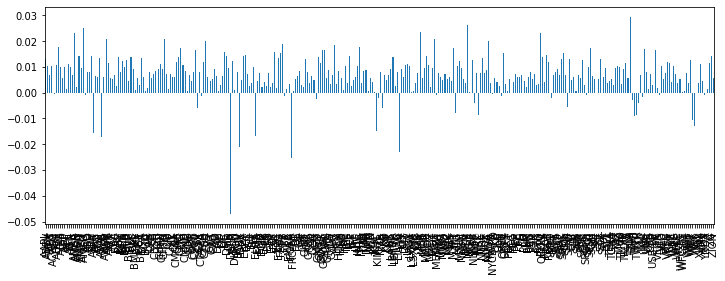

In [0]:
wret = np.log(prices.resample('W').last()/prices.resample('W').last().shift(1))
rwret = np.log(prices/prices.shift(5))

mret = np.log(prices.resample('M').last()/prices.resample('M').last().shift(1))
rmret = np.log(prices/prices.shift(22))

raret = np.log(prices/prices.shift(252))

rwret.mean().mul(4).plot(kind='bar', figsize=(12,4))
plt.show()

In [0]:
wret = wret[assetsDF.index]
tret = raret[assetsDF.index].copy()

assetsDF['Risk'] = tret[tret < 0.0].count()/tret[tret != 0.0].count()
tret = tret.round(2)
assetsDF['Exp.Ret'] = 0.0

for n in range(201):
    assetsDF['Exp.Ret'] += tret.quantile(n/200) * tret[tret==tret.quantile(n/200)].count()/tret.count()

assetsDF['STD'] = raret.std()

### Collecting dividends

In [0]:
dividends = pd.DataFrame(index=prices.index, columns=prices.columns).resample('D').last()

for a in prices.columns:
    divs = yf.Ticker(a).dividends
    dividends.loc[divs.index, a] = divs

dividends = dividends.resample('M').sum()

assetsDF['Yield'] = 0.0
assetsDF.loc[dividends.columns, 'Yield'] = dividends.resample('A').sum().iloc[-1]/prices[dividends.columns].iloc[-1]
#assetsDF.sort_values(by='Yield', ascending=False).head(15)

In [0]:
adjPrices = data['Adj Close'][prices.columns]
ret = np.log(prices/prices.shift(1)).fillna(0.0)

## Dividends

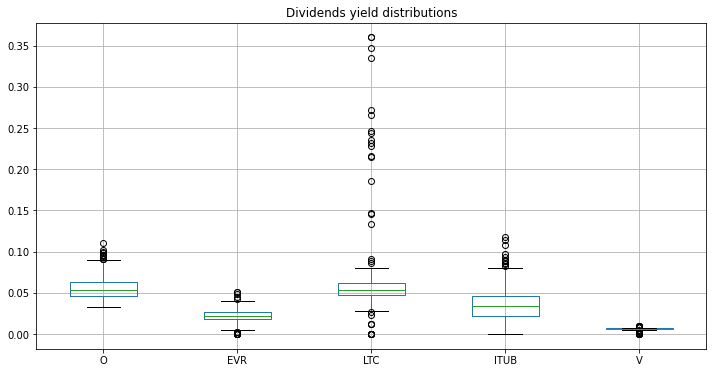

In [0]:
yields = dividends.rolling(12).sum().div(prices.resample('M').last().loc[dividends.index])
yields.loc['2000':, portAssets].boxplot(figsize=(12,6))
plt.title('Dividends yield distributions')
plt.show();

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


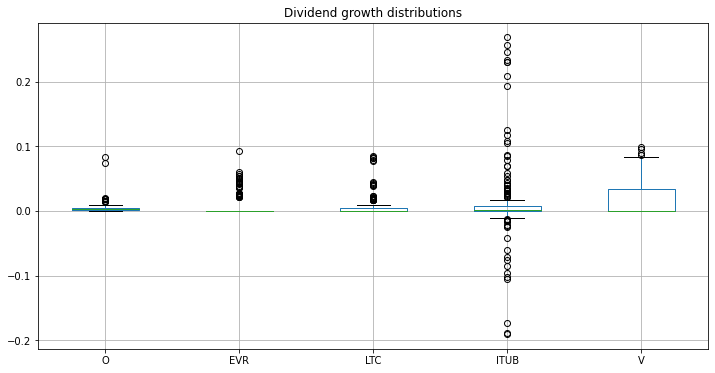

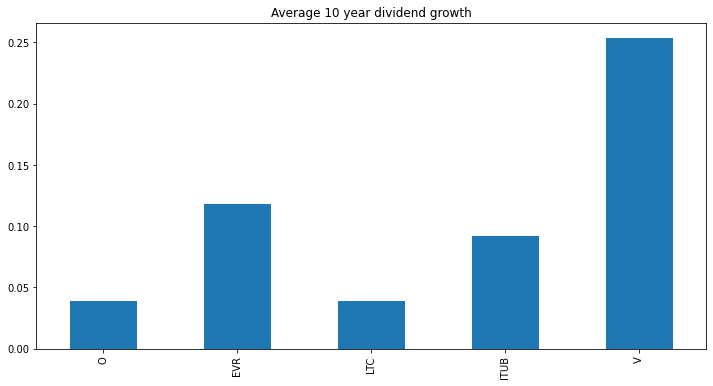

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


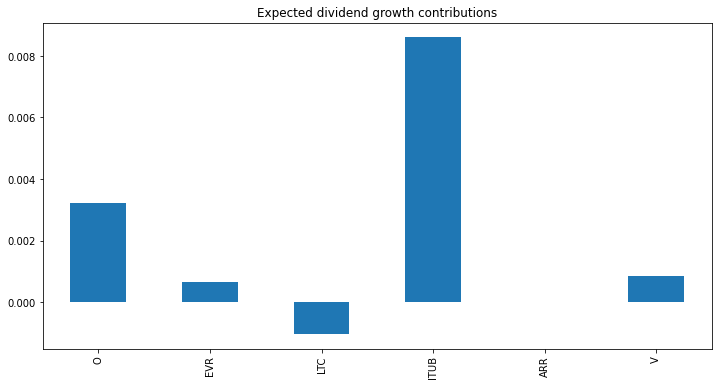

In [0]:
divGrowth = dividends.rolling(12).sum().fillna(0)
divGrowth = np.log(divGrowth/divGrowth.shift(1))

for a in divGrowth.columns:
    if divGrowth[a].max() == np.inf or divGrowth[a].min() == -np.inf:
        divGrowth.loc[divGrowth[a] == np.inf, a] = divGrowth[a].drop_duplicates().sort_values()[-3]
        divGrowth.loc[divGrowth[a] == -np.inf,a] = divGrowth[a].drop_duplicates().sort_values()[2]
    divGrowth.loc[divGrowth[a] > divGrowth[a].quantile(0.95), a] = 0.0
    divGrowth.loc[divGrowth[a] < divGrowth[a].quantile(0.05), a] = 0.0

divGrowth[portAssets].boxplot(figsize=(12,6))
plt.title('Dividend growth distributions')
plt.show();

dg = dividends.rolling(12).sum().iloc[-1].div(dividends.rolling(12).sum().iloc[-120])**(1/10)-1
dg = dg[np.logical_and(dg != np.inf, dg != -np.inf)]
dg[portAssets].plot(kind='bar', figsize=(12,6), 
                    title='Average 10 year dividend growth')
plt.show();

dgr = np.log(dividends.rolling(12).sum()/dividends.rolling(12).sum().shift(1)).fillna(0.0)
exp_dgr = pd.Series(index=dgr.columns)
for a in dgr.columns:
    if dgr[a].max() == np.inf: dgr.loc[dgr[a] == np.inf, a] = dgr[a].drop_duplicates().sort_values()[-2];
    if dgr[a].min() == -np.inf: dgr.loc[dgr[a] == -np.inf, a] = dgr[a].drop_duplicates().sort_values()[1];

    exp_dgr.loc[a] = 0.0
    for n in range(101):
        exp_dgr.loc[a] += dgr[a].quantile(n/100) * 0.01

assetsDF.loc[exp_dgr.index, 'Div Growth'] = exp_dgr

divGrowDF = pd.DataFrame({'AVG Growth':dgr.mean(), 'Expected Growth':exp_dgr}).sort_values(by='Expected Growth', ascending=False)

exp_dgr[w.index].mul(w).plot(kind='bar', 
                             title='Expected dividend growth contributions', 
                             
                             figsize=(12,6))
plt.show()

In [0]:
print('Portfolio historical dividend growth: {}%'.format(round(100*np.dot(dg[w.index], w),2)))
print('Expected portfolio dividend growth: {}%'.format(round(100*np.dot(exp_dgr[w.index], w),2)))

Portfolio historical dividend growth: nan%
Expected portfolio dividend growth: nan%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':


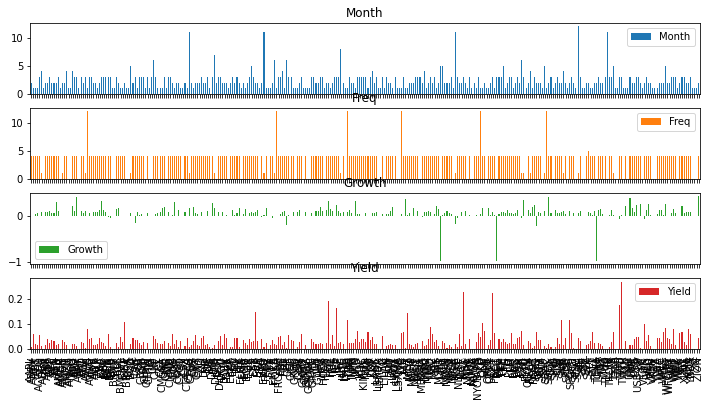

In [0]:
divMonths = pd.DataFrame(index=prices.columns, columns=list(['Month','Freq']))
divMonths['Growth'] = dg.fillna(0.0)

for a in prices.columns:
    
    divs = dividends[a].iloc[-60:]
    m = pd.Series(np.zeros(12), index=list(range(1,13)))
    for i in divs.index:
        if divs.loc[i] != 0.0:
            m.loc[i.month] += 1
    
    mt = m[m>0.0]/(60/m[m>0.0].count())
    
    if mt.count() != 4 and mt.count() != 12 and mt.count() != 1:
        if len(m[m>=m.mean()].index) > 0:
            mt = mt[mt >= mt.mean()]
    
    if mt.count() > 0:
        m = mt
    
    #print(m)
    divMonths.loc[a,'Month'] = m.index[0]
    divMonths.loc[a,'Freq'] = m.count()

divMonths.loc[divMonths['Freq'] == 3, 'Freq'] = 4
divMonths.loc[divMonths['Freq'] >= 6, 'Freq'] = 12
divMonths.loc[divMonths['Freq'] == 2, 'Freq'] = 1

divMonths['Yield'] = round(dividends.rolling(12).sum().iloc[-1]/prices.iloc[-1],4)
divMonths.loc[divMonths['Yield']<0.001, 'Freq'] = 0

divMonths = divMonths.fillna(0)

assetsDF['Div.FREQ'] = 0
assetsDF['Div.Month'] = 0
assetsDF.loc[divMonths.index, 'Div.FREQ'] = divMonths['Freq']
assetsDF.loc[divMonths.index, 'Div.Month'] = divMonths['Month']

divMonths.plot(kind='bar', subplots=True, figsize=(12,6))
plt.show()

In [0]:
assetsDF.loc[portAssets]

,Name,Industry,Sub-Industry,Risk,Exp.Ret,STD,Yield,Div Growth,Div.FREQ,Div.Month
O,Realty Income Corporation,Real Estate,REIT—Retail,0.295146,0.361953,0.155940,0.018048,0.008548,12,1
EVR,Evercore Inc.,Financial Services,Capital Markets,0.458930,0.089173,0.407959,0.011077,0.008690,4,2
LTC,"LTC Properties, Inc.",Real Estate,REIT—Healthcare Facilities,0.329513,0.233475,0.298478,0.026700,-0.005634,12,1
ITUB,Itau Unibanco Holding S.A.,Financial Services,Banks—Regional,0.360203,0.198770,0.390382,0.061689,0.032226,12,1
V,Visa Inc.,Financial Services,Credit Services,0.106179,0.856282,0.172318,0.003167,0.008634,4,2


## Technical Analysis

In [0]:
assetsDF['S-Signal'] = 0
assetsDF['M-Signal'] = 0
assetsDF['L-Signal'] = 0

assetsDF['S-Prob'] = 0.
assetsDF['M-Prob'] = 0.
assetsDF['L-Prob'] = 0.

assetsDF['S-Ret'] = 0.
assetsDF['M-Ret'] = 0.
assetsDF['L-Ret'] = 0.

for a in assetsDF.index:
    ss, prob, rets = expectedReturn(prices[a], a, output='tripple')
    minr = expectedReturn(prices[a], a=a, output='loss')

    assetsDF.loc[a, 'S-Signal'] = ss['S']
    assetsDF.loc[a, 'M-Signal'] = ss['M']
    assetsDF.loc[a, 'L-Signal'] = ss['L']

    assetsDF.loc[a, 'S-Prob'] = prob['S']
    assetsDF.loc[a, 'M-Prob'] = prob['M']
    assetsDF.loc[a, 'L-Prob'] = prob['L']

    assetsDF.loc[a, 'S-Ret'] = rets['S']
    assetsDF.loc[a, 'M-Ret'] = rets['M']
    assetsDF.loc[a, 'L-Ret'] = rets['L']

    assetsDF.loc[a, 'S-Loss'] = minr['S']
    assetsDF.loc[a, 'M-Loss'] = minr['M']
    assetsDF.loc[a, 'L-Loss'] = minr['L']

assetsDF[assetsDF['S-Loss']>-0.05]

,Name,Industry,Sub-Industry,Risk,Exp.Ret,STD,Yield,Div Growth,Div.FREQ,Div.Month,S-Signal,M-Signal,L-Signal,S-Prob,M-Prob,L-Prob,S-Ret,M-Ret,L-Ret,S-Loss,M-Loss,L-Loss
ACGLO,Arch Capital Group Ltd.,Financial Services,Insurance—Diversified,0.434091,0.132398,0.110621,0.013750,0.003995,4,3,0.537415,0.581633,0.738095,0.072539,0.264249,0.481865,0.034249,0.259585,0.847098,-0.034865,-0.079302,-0.027143
ACN,Accenture plc,Technology,Information Technology Services,0.190731,0.556530,0.176045,0.008326,0.003894,1,4,0.650082,0.774878,0.793638,0.555556,0.666667,0.777778,1.375556,2.313333,0.248889,0.000000,0.000000,0.000000
ADI,"Analog Devices, Inc.",Technology,Semiconductors,0.372806,0.133533,0.396070,0.005638,0.008252,4,2,0.546667,0.598095,0.594014,0.352941,0.411765,0.529412,0.060588,0.134118,-0.339412,-0.035714,-0.088750,-0.267143
ALB,Albemarle Corporation,Basic Materials,Specialty Chemicals,0.397982,0.174802,0.284720,0.005736,0.006696,4,3,0.000000,0.000000,0.000000,0.333333,0.333333,0.000000,0.026667,0.053333,-0.046667,0.000000,0.000000,-0.150000
AMBA,"Ambarella, Inc.",Technology,Semiconductor Equipment & Materials,0.398799,0.171640,0.525740,0.000000,0.000000,0,1,-0.736879,-0.563166,-0.565764,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WRK,WestRock Company,Consumer Cyclical,Packaging & Containers,0.522796,-0.076505,0.322167,0.026394,0.005853,4,2,0.511858,0.484190,0.328063,0.125000,0.125000,0.000000,-0.232500,-0.912500,-0.045000,-0.046000,-0.088333,-0.262000
XEL,Xcel Energy Inc.,Utilities,Utilities—Regulated Electric,0.305625,0.280047,0.207283,0.007169,0.005350,4,3,0.000000,0.000000,0.000000,0.328767,0.164384,0.232877,0.798493,0.158630,-0.198630,-0.011667,-0.058696,-0.135778
XOM,Exxon Mobil Corporation,Energy,Oil & Gas Integrated,0.331368,0.265680,0.172408,0.039633,0.005672,4,2,0.503254,0.474857,0.577401,0.142857,0.142857,0.483516,-0.048791,-0.164945,0.098681,-0.048235,-0.065455,-0.089231
Z,"Zillow Group, Inc.",Communication Services,Internet Content & Information,0.296875,0.329000,0.288378,0.000000,0.000000,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [0]:
industries = pd.DataFrame(index=indRet.columns)
industries['S-Signal'] = 0
industries['M-Signal'] = 0
industries['L-Signal'] = 0

industries['S-Prob'] = 0.
industries['M-Prob'] = 0.
industries['L-Prob'] = 0.

industries['S-Ret'] = 0.
industries['M-Ret'] = 0.
industries['L-Ret'] = 0.

for a in industries.index:
    ss, prob, rets = expectedReturn(indPrice[a], a=a, output='tripple')
    minr = expectedReturn(indPrice[a], a=a, output='loss')

    industries.loc[a, 'S-Signal'] = ss['S']
    industries.loc[a, 'M-Signal'] = ss['M']
    industries.loc[a, 'L-Signal'] = ss['L']

    industries.loc[a, 'S-Prob'] = prob['S']
    industries.loc[a, 'M-Prob'] = prob['M']
    industries.loc[a, 'L-Prob'] = prob['L']

    industries.loc[a, 'S-Ret'] = rets['S']
    industries.loc[a, 'M-Ret'] = rets['M']
    industries.loc[a, 'L-Ret'] = rets['L']

    industries.loc[a, 'S-Loss'] = minr['S']
    industries.loc[a, 'M-Loss'] = minr['M']
    industries.loc[a, 'L-Loss'] = minr['L']


Creating moving averages
Creating boolenial bands


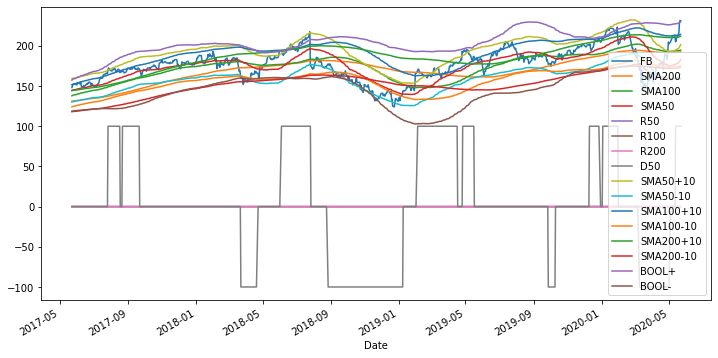

Creating boolenial signals
Creating moving average signals
Adding some history...
Calculating returns
Finding current state
Calculating expected return and probability of profitability of current state


S   -0.085000
M   -0.171429
L   -0.010000
dtype: float64

In [0]:
expectedReturn(prices['FB'], a='FB', verbose=True, output='loss')


In [0]:
#industries.plot(kind='bar', subplots=True, figsize=(12,16))
#plt.show()

industries

,S-Signal,M-Signal,L-Signal,S-Prob,M-Prob,L-Prob,S-Ret,M-Ret,L-Ret,S-Loss,M-Loss,L-Loss
Market,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Basic Materials,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Consumer Cyclical,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Financial Services,0.000000,0.000000,0.000000,0.000000,0.027778,0.138889,-0.804722,-2.525556,-0.585833,-0.334516,-0.366667,-0.165217
Real Estate,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.010000,-0.210000,0.050000,0.000000,-0.420000,0.000000
Consumer Defensive,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Healthcare,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Utilities,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Communication Services,0.772436,0.634615,0.608974,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Energy,0.641944,0.618926,0.457801,0.304348,0.000000,0.000000,0.105217,-0.119565,0.000000,-0.410000,-0.100000,0.000000


In [0]:
hppDF = assetsDF.copy()

for ind in industries.loc[industries[['S-Ret','M-Ret','L-Ret']].min(axis=1)<=0.0].index:
    hppDF = hppDF[hppDF['Industry'] != ind]


hppDF.loc[hppDF[['S-Ret','M-Ret','L-Ret']].min(axis=1)>rmret.std().mul(2).mean()].sort_values(by='S-Ret',ascending=False)

,Name,Industry,Sub-Industry,Risk,Exp.Ret,STD,Yield,Div Growth,Div.FREQ,Div.Month,S-Signal,M-Signal,L-Signal,S-Prob,M-Prob,L-Prob,S-Ret,M-Ret,L-Ret,S-Loss,M-Loss,L-Loss


In [0]:
assetsDF.loc[assetsDF['S-Signal'] > max(.75, assetsDF['S-Signal'].median())]

,Name,Industry,Sub-Industry,Risk,Exp.Ret,STD,Yield,Div Growth,Div.FREQ,Div.Month,S-Signal,M-Signal,L-Signal,S-Prob,M-Prob,L-Prob,S-Ret,M-Ret,L-Ret,S-Loss,M-Loss,L-Loss
EBAY,eBay Inc.,Consumer Cyclical,Internet Retail,0.358846,0.177773,0.37688,0.003725,0.004169,4,2,1.074074,1.148148,1.407407,0.0,0.0,0.8,2.434,-1.878,9.124,0.0,-0.0975,0.0


## Linear regression

In [0]:
assetsDF['LR WRet'] = 0.0
assetsDF['LR R2'] = 0.0

olsParams = pd.DataFrame(index=indRet.columns.to_list() + factRet.columns.to_list(), columns=assetsDF.index)
olsPvalues = pd.DataFrame(index=indRet.columns.to_list() + factRet.columns.to_list(), columns=assetsDF.index)
startDate = factRet.dropna().index[0]

for a in assetsDF.index:    
    #startDate = indRet[['Market', assetsDF.loc[a, 'Industry']]].dropna().index[0]
    olsParams[a] = 0.0
    
    if startDate > wret[a].dropna().index[0]:    
        y = wret.loc[startDate:, a].dropna()    
        #X = indRet.loc[startDate:, ['Market', assetsDF.loc[a, 'Industry']]].dropna()
        X = indRet.loc[startDate:].dropna()

        for c in factRet.columns:
            X[c] = factRet[c]
        
        X['LAG'] = y.shift(3)
        X['SMA'] = y.rolling(3).mean().fillna(0.0)
        olsParams.loc['LAG', a] = 0.0
        olsParams.loc['SMA', a] = 0.0
        olsPvalues.loc['LAG', a] = 0.0
        olsPvalues.loc['SMA', a] = 0.0

        r = X.iloc[-1]
        X = X.shift(1).fillna(0.0)
        
        model = sm.OLS(y,X)
        results = model.fit()
        olsParams.loc[X.columns.to_list(), a] = results.params
        olsPvalues.loc[X.columns.to_list(), a] = results.pvalues

        assetsDF.loc[a, 'LR R2'] = results.rsquared
        assetsDF.loc[a, 'LR W Ret'] = np.dot(results.params,r)
        #print(a, results.pvalues)
        #print(results.summary())

olsParams.to_csv('Factor Exposures.csv')
olsPvalues.to_csv('Factor P-Values.csv')

assetsDF[['Name','Industry','S-Ret','S-Prob','LR W Ret','LR R2']].sort_values(by='LR R2', ascending=False).head(20)

,Name,Industry,S-Ret,S-Prob,LR W Ret,LR R2
NLY-PF,"Annaly Capital Management, Inc.",Real Estate,0.000000,0.000000,-0.017072,0.646090
TWO,Two Harbors Investment Corp.,Real Estate,0.097377,0.147541,-0.020435,0.631097
SPG,"Simon Property Group, Inc.",Real Estate,0.072526,0.347368,-0.006558,0.609076
NRZ,New Residential Investment Corp.,Real Estate,0.087959,0.346939,-0.029478,0.606057
BA,The Boeing Company,Industrials,0.026370,0.358512,0.033006,0.590462
ACGLO,Arch Capital Group Ltd.,Financial Services,0.034249,0.072539,-0.003914,0.589995
OKE,"ONEOK, Inc.",Energy,0.099570,0.346154,0.092352,0.581807
WELL,Welltower Inc.,Real Estate,0.049098,0.290984,-0.029045,0.581289
IHG,InterContinental Hotels Group PLC,Consumer Cyclical,0.194618,0.461847,0.008826,0.579468
FRT,Federal Realty Investment Trust,Real Estate,0.178400,0.160000,0.001897,0.578771


In [0]:
suggestions = []


for ind in assetsDF['Industry'].drop_duplicates().values:
    tDF = assetsDF.loc[assetsDF['Industry']==ind]
    tDF = tDF[np.logical_and(tDF['S-Ret']>max(0.0,tDF['S-Ret'].median()),
                             tDF['Risk']<tDF['Risk'].mean())]
    tDF = tDF[np.logical_and(tDF['Exp.Ret']>=max(0.0,tDF['Exp.Ret'].median()),
                             tDF['S-Loss']<=tDF['S-Loss'])]
    tDF = tDF[np.logical_and(tDF[['S-Prob','M-Prob','L-Prob']].mean(axis=1)>0.5,
                             tDF[['S-Signal','M-Signal','L-Signal']].min(axis=1)>0.0)]
    tDF = tDF.sort_values(by='L-Ret',ascending=False).drop_duplicates('Sub-Industry')
    
    suggestions += tDF.index.to_list()

assetsDF.loc[suggestions]

,Name,Industry,Sub-Industry,Risk,Exp.Ret,STD,Yield,Div Growth,Div.FREQ,Div.Month,S-Signal,M-Signal,L-Signal,S-Prob,M-Prob,L-Prob,S-Ret,M-Ret,L-Ret,S-Loss,M-Loss,L-Loss,LR WRet,LR R2,LR W Ret,Beta,CORR
APH,Amphenol Corporation,Technology,Electronic Components,0.253688,0.405219,0.328924,0.002784,0.012898,4,3,0.623565,0.675529,0.809668,0.500000,0.794118,0.794118,0.895294,0.657059,1.275294,-0.091667,-0.036667,-0.052500,0.0,0.392379,0.022708,0.744426,0.137167
ACN,Accenture plc,Technology,Information Technology Services,0.190731,0.556530,0.176045,0.008326,0.003894,1,4,0.650082,0.774878,0.793638,0.555556,0.666667,0.777778,1.375556,2.313333,0.248889,0.000000,0.000000,0.000000,0.0,0.365696,0.003020,0.925976,0.292432
NTRA,"Natera, Inc.",Healthcare,Diagnostics & Research,0.253564,0.445550,0.382644,0.000000,0.000000,0,1,0.731111,0.795556,0.713333,0.545455,0.545455,0.545455,0.201818,0.244545,0.302727,0.000000,0.000000,0.000000,0.0,0.185148,0.092548,0.922542,0.112263
UNP,Union Pacific Corporation,Industrials,Railroads,0.290137,0.443300,0.234636,0.005904,0.007995,4,2,0.542611,0.571976,0.787424,0.378378,0.378378,0.905405,0.211081,0.231486,0.688514,-0.060833,-0.095238,-0.185000,0.0,0.370150,0.004918,1.261040,0.339815
ROP,"Roper Technologies, Inc.",Industrials,Specialty Industrial Machinery,0.200408,0.564994,0.310807,0.002814,0.008901,4,1,0.639193,0.662824,0.845533,0.475000,0.400000,0.750000,0.336500,0.087250,0.431000,-0.084000,-0.141333,-0.260000,0.0,0.370028,-0.004159,1.011336,0.258974
ADP,"Automatic Data Processing, Inc.",Industrials,Staffing & Employment Services,0.196816,0.479248,0.182573,0.006825,0.011426,4,3,0.574493,0.625585,0.760920,0.377358,0.654088,0.490566,0.150503,0.532264,0.260440,-0.075283,-0.076154,-0.109348,0.0,0.377885,0.026759,0.196100,0.067136
ICE,"Intercontinental Exchange, Inc.",Financial Services,Financial Data & Stock Exchanges,0.129336,0.516005,0.324456,0.003233,0.006463,4,3,0.589777,0.575360,0.816514,0.361582,0.593220,0.745763,0.207119,0.430339,0.720508,-0.079245,-0.108571,-0.034737,0.0,0.364772,0.022306,2.389607,0.375156
BRK-A,Berkshire Hathaway Inc.,Financial Services,Insurance—Diversified,0.193303,0.421355,0.219421,0.000000,0.000000,0,1,0.587029,0.687448,0.820084,0.377551,0.489796,0.653061,0.087245,0.104490,0.534286,-0.085000,-0.092647,-0.067778,0.0,0.235068,0.013113,0.906150,0.292037
SYY,Sysco Corporation,Consumer Defensive,Food Distribution,0.243828,0.334925,0.232908,0.017483,-0.004691,4,1,0.511614,0.575867,0.693213,0.388489,0.431655,0.744604,0.130755,0.002914,1.889388,-0.122500,-0.201226,-0.115333,0.0,0.534631,0.011067,1.031755,0.370484
STZ,"Constellation Brands, Inc.",Consumer Defensive,Beverages—Wineries & Distilleries,0.303407,0.341715,0.306931,0.008833,0.008298,4,2,0.620656,0.593735,0.594714,0.655172,0.482759,0.482759,0.340345,0.355862,0.149655,-0.052500,-0.139286,-0.166364,0.0,0.458939,0.002244,1.513842,0.288622


## Correlations

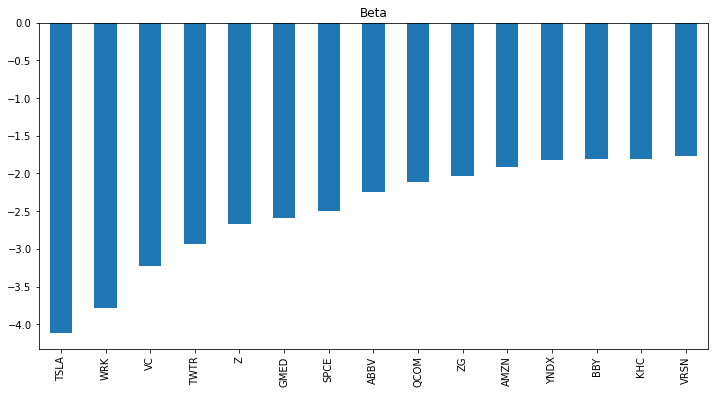

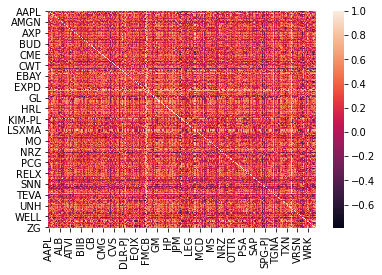

,Name,Industry,Sub-Industry,Risk,Exp.Ret,STD,Yield,Div Growth,Div.FREQ,Div.Month,S-Signal,M-Signal,L-Signal,S-Prob,M-Prob,L-Prob,S-Ret,M-Ret,L-Ret,S-Loss,M-Loss,L-Loss,LR WRet,LR R2,LR W Ret,Beta,CORR
GMED,"Globus Medical, Inc.",Healthcare,Medical Devices,0.275439,0.428283,0.237484,0.000000,0.000000,0,1,0.637209,0.660465,0.734884,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.326350,0.025007,-2.593898,-0.590285
WRK,WestRock Company,Consumer Cyclical,Packaging & Containers,0.522796,-0.076505,0.322167,0.026394,0.005853,4,2,0.511858,0.484190,0.328063,0.125000,0.125000,0.000000,-0.232500,-0.912500,-0.045000,-0.046000,-0.088333,-0.262,0.0,0.285869,0.003392,-3.782763,-0.544390
ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers—General,0.336025,0.235857,0.221845,0.025613,0.008580,4,1,0.000000,0.000000,0.000000,0.348993,0.516779,0.704698,0.207383,0.264430,0.534922,-0.062317,-0.076000,-0.106,0.0,0.317669,-0.035775,-2.245610,-0.536600
VC,Visteon Corporation,Consumer Cyclical,Auto Parts,0.417855,0.105616,0.379409,0.000000,0.000000,0,1,0.505882,0.518717,0.587166,0.000000,0.500000,0.000000,0.005000,0.185000,0.000000,0.000000,0.000000,0.000,0.0,0.293428,0.030492,-3.224178,-0.490260
TSLA,"Tesla, Inc.",Consumer Cyclical,Auto Manufacturers,0.314897,0.184269,0.531708,0.000000,0.000000,0,1,0.609954,0.731481,0.559028,0.444444,0.111111,0.222222,0.058889,-0.008889,0.621111,-0.047500,-0.134000,-0.080,0.0,0.187420,-0.017075,-4.119560,-0.452164
Z,"Zillow Group, Inc.",Communication Services,Internet Content & Information,0.296875,0.329000,0.288378,0.000000,0.000000,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.339186,0.035477,-2.670857,-0.441594
SPCE,"Virgin Galactic Holdings, Inc.",Industrials,Aerospace & Defense,0.242647,0.232415,0.271109,0.000000,0.000000,0,1,0.000000,0.000000,0.000000,0.142857,0.142857,0.000000,0.090000,0.284286,0.000000,0.000000,0.000000,0.000,0.0,0.328731,0.045582,-2.491488,-0.430897
PYPL,"PayPal Holdings, Inc.",Financial Services,Credit Services,0.037755,0.791694,0.187239,0.000000,0.000000,0,1,0.553903,0.524164,0.646840,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.367352,-0.005855,-1.525994,-0.380353
TWTR,"Twitter, Inc.",Communication Services,Internet Content & Information,0.548780,-0.024832,0.461872,0.000000,0.000000,0,1,0.465450,0.367666,0.314211,0.500000,0.250000,0.500000,0.032500,0.025000,0.182500,0.000000,-0.080000,0.000,0.0,0.255693,-0.030775,-2.940238,-0.329207
ZG,"Zillow Group, Inc.",Communication Services,Internet Content & Information,0.290127,0.317154,0.374524,0.000000,0.000000,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.338173,0.048009,-2.030994,-0.301842


In [0]:
assetsDF['Beta'] = 0.0
assetsDF['CORR'] = 0.0

raret['PORT'] = 0.0
raret['PORT'] = raret[portAssets].mul(cportDF.loc['Weight', portAssets], axis=1)
assetsDF['Beta'] = (raret.cov()['PORT']/raret['PORT'].var()).drop('PORT')

assetsDF['Beta'].sort_values().head(15).plot(kind='bar', figsize=(12,6))
plt.title('Beta')
plt.show();

assetsDF['CORR'] = raret.corr()['PORT'].drop('PORT')

sn.heatmap(raret.corr().drop('PORT',axis=0).drop('PORT',axis=1))
plt.show();

raret = raret.drop('PORT', axis=1)
assetsDF.sort_values(by='CORR').head(10)

In [0]:
assetsDF[np.logical_and(assetsDF['Div Growth'] > 0.0, assetsDF['Div.FREQ'] >= 11)]

,Name,Industry,Sub-Industry,Risk,Exp.Ret,STD,Yield,Div Growth,Div.FREQ,Div.Month,S-Signal,M-Signal,L-Signal,S-Prob,M-Prob,L-Prob,S-Ret,M-Ret,L-Ret,S-Loss,M-Loss,L-Loss,LR WRet,LR R2,LR W Ret,Beta,CORR
AVAL,Grupo Aval Acciones y Valores S.A.,Financial Services,Banks—Regional,0.525149,-0.032245,0.236210,0.026716,0.000410,12,1,0.455344,0.440703,0.537335,0.495495,0.396396,0.621622,0.335045,0.124505,0.511802,-0.061304,-0.109487,-0.128667,0.0,0.520393,0.068490,0.267264,0.055311
FOXA,Fox Corporation,Communication Services,Broadcasting,1.000000,-3.099808,0.081505,0.008303,0.002877,12,1,0.562500,0.289062,0.000000,0.500000,0.500000,0.000000,0.045000,0.080000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN,0.449651,0.485584
ITUB,Itau Unibanco Holding S.A.,Financial Services,Banks—Regional,0.360203,0.198770,0.390382,0.061689,0.032226,12,1,0.534408,0.576565,0.530688,0.470588,0.352941,0.529412,0.132941,0.070882,0.193824,-0.118750,-0.137857,-0.124545,0.0,0.302675,-0.029154,1.906502,0.268032
O,Realty Income Corporation,Real Estate,REIT—Retail,0.295146,0.361953,0.155940,0.018048,0.008548,12,1,0.581011,0.596127,0.666509,0.626866,0.447761,0.462687,0.295970,0.077313,0.174925,-0.110000,-0.076000,-0.026250,0.0,0.550261,-0.013355,2.645108,1.000000
SBAC,SBA Communications Corporation,Real Estate,REIT—Specialty,0.243125,0.347678,0.856670,0.001606,0.006931,12,1,0.000000,0.000000,0.000000,0.345361,0.543446,0.695140,0.181009,0.261782,0.364816,-0.054161,-0.096331,-0.181270,0.0,0.272209,-0.008294,-0.234607,-0.015693


In [0]:
assetsDF.to_csv('assets.csv')

## Portfolio overview

In [0]:
expRet = assetsDF.loc[portAssets, 'Exp.Ret'].mul(cportDF.loc['Weight', portAssets]).sum()
print('\nPortfolio expected return: {}%'.format(100*round(expRet,4)))
expRet = assetsDF.loc[portAssets, 'S-Ret'].mul(w).sum()
print('Expected short term return: {}%'.format(100*round(expRet,4)))
print('Expected one year return: {}%'.format(round(100*assetsDF.loc[portAssets, 'L-Ret'].mul(w).sum(),2)))

assetsDF.loc[portAssets]


Portfolio expected return: 32.31%
Expected short term return: 19.75%
Expected one year return: 36.03%


,Name,Industry,Sub-Industry,Risk,Exp.Ret,STD,Yield,Div Growth,Div.FREQ,Div.Month,S-Signal,M-Signal,L-Signal,S-Prob,M-Prob,L-Prob,S-Ret,M-Ret,L-Ret,S-Loss,M-Loss,L-Loss,LR WRet,LR R2,LR W Ret,Beta,CORR
O,Realty Income Corporation,Real Estate,REIT—Retail,0.295146,0.361953,0.155940,0.018048,0.008548,12,1,0.581011,0.596127,0.666509,0.626866,0.447761,0.462687,0.295970,0.077313,0.174925,-0.110000,-0.076000,-0.026250,0.0,0.550261,-0.013355,2.645108,1.000000
EVR,Evercore Inc.,Financial Services,Capital Markets,0.458930,0.089173,0.407959,0.011077,0.008690,4,2,0.538259,0.539578,0.542876,0.550000,0.600000,0.500000,0.568500,0.205000,0.064000,-0.047143,-0.358571,-0.087500,0.0,0.434961,0.053593,1.789201,0.219661
LTC,"LTC Properties, Inc.",Real Estate,REIT—Healthcare Facilities,0.329513,0.233475,0.298478,0.026700,-0.005634,12,1,0.534440,0.640664,0.622407,0.192308,0.384615,0.692308,-0.300769,0.477692,0.419615,-0.093750,-0.099091,-0.600000,0.0,0.548293,0.016254,2.492722,0.474913
ITUB,Itau Unibanco Holding S.A.,Financial Services,Banks—Regional,0.360203,0.198770,0.390382,0.061689,0.032226,12,1,0.534408,0.576565,0.530688,0.470588,0.352941,0.529412,0.132941,0.070882,0.193824,-0.118750,-0.137857,-0.124545,0.0,0.302675,-0.029154,1.906502,0.268032
V,Visa Inc.,Financial Services,Credit Services,0.106179,0.856282,0.172318,0.003167,0.008634,4,2,0.000000,0.000000,0.000000,0.510638,0.531915,0.914894,0.633404,0.782128,1.642766,-0.034286,-0.020000,0.000000,0.0,0.369454,-0.000316,0.358536,0.110296


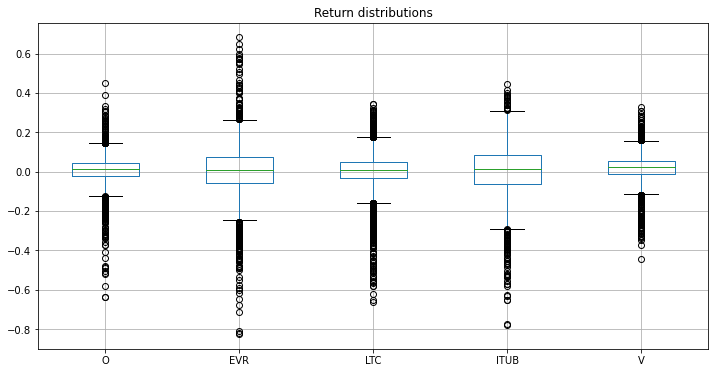

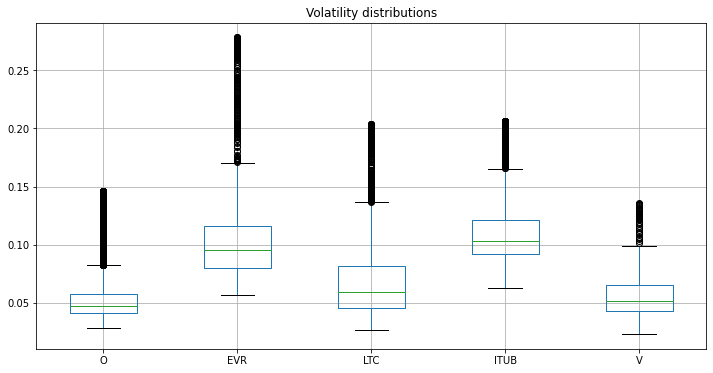

In [0]:
rmret[portAssets].boxplot(figsize=(12,6))
plt.title('Return distributions')
plt.show();

rmret[portAssets].rolling(252).std().boxplot(figsize=(12,6))
plt.title('Volatility distributions')
plt.show();

# Asset selection

## Dividend trio selection

In [0]:
qDivs = divMonths[divMonths['Freq']==4].sort_index()
first = qDivs[qDivs['Month']==1]
second = qDivs[qDivs['Month']==2]
third = qDivs[qDivs['Month']==3]

corrPass = assetsDF['CORR'].abs().quantile(0.75)
len(first), len(second), len(third), corrPass

(41, 97, 92, 0.3746344783340766)

In [0]:
first = first[np.logical_and(first['Yield']>0.02, 
                             first['Growth']>=first['Growth'].mean())]

second = second[np.logical_and(second['Yield']>0.02,
                               second['Growth']>=second['Growth'].mean())]

third = third[np.logical_and(third['Yield']>0.02,
                             third['Growth']>=third['Growth'].mean())]

len(first), len(second), len(third)

(9, 26, 31)

In [0]:
std = 1.0
mu = 0.0
rRisk = 1.0
dRisk = 1.0
pUpside = 0.0
dGrow = 0.0

DiYselect = []
tPort = []
for i in first.index:
    if i not in portAssets and abs(assetsDF.loc[i,'CORR']) < corrPass:        
        for ii in second.index:
            if ii not in portAssets and abs(assetsDF.loc[ii,'CORR']) < corrPass and assetsDF.loc[ii,'Industry'] != assetsDF.loc[i,'Industry']:
                for iii in third.index:
                    #print(assetsDF.loc[portAssets+[i,ii,iii]])
                    portIndC = assetsDF.loc[portAssets, 'Industry'].drop_duplicates().count()
                    if assetsDF.loc[portAssets+[i,ii,iii],'Industry'].drop_duplicates().count() == 3+portIndC:
                        if (iii not in portAssets) and abs(assetsDF.loc[iii,'CORR']) < corrPass:
                            tPort = [i,ii,iii]
                            #print(assetsDF.loc[tPort])

                            pRet = ret[tPort].rolling(52).sum().mean(axis=1).dropna()
                            tSTD = pRet.std()
                            upside = 1 - pRet[pRet < -0.07].std()/pRet.std()

                            tMu = 0.0
                            for n in range(101):
                                tMu += pRet.quantile(n/100).mean() * 0.01

                            trRisk =  pRet[pRet<-0.07].count()/pRet.count()
                            tDGR = divGrowth[tPort].mean(axis=1)
                            tdRisk = tDGR[tDGR < 0.0].count()/tDGR.count()
                            pdGrow = exp_dgr.loc[tPort].mean()
                            inPort = 0
                            for a in tPort:
                                if a in cportDF.columns: inPort += 1

                            #print(tPort, tMu, trRisk, pdGrow, tdRisk)
                            if trRisk <= 0.5 and pdGrow > 0.0:
                                if (1+tDGR.mean())/(1+tdRisk) >= (1+dGrow)/(1+dRisk) and (1+tMu)/(1+trRisk) >= (1+mu)/(1+rRisk) and inPort < 3:
                                    
                                    DiYselect = [i, ii, iii]
                                    std = tSTD
                                    mu = tMu
                                    dRisk = tdRisk
                                    rRisk = trRisk
                                    pUpside = upside
                                    dGrow = pdGrow

                                    print(tPort, round((1+mu)/(1+rRisk),3), round((1+dGrow)/(1+dRisk),3))
        print(first.index.to_list().index(i), i, tPort, round((1+tMu)/(1+trRisk),2), round((1+tDGR.mean())/(1+tdRisk),2))

print('\nMini-Portfolio Expected Return: {}%'.format(100*round(mu,4)))
print('Mini-Portfolio STD: {}%'.format(100*round(std,4)))
print('Mini-Portfolio Risk: {}%'.format(100*round(rRisk,4)))
print('Mini-Portfolio upside potential: {}%'.format(100*round(pUpside,4)))
print('Mini-Portfolio Dividend growth: {}%'.format(100*round(dGrow,4)))
print('Mini-Portfolio Dividend Risk: {}%'.format(100*round(dRisk,4)))

['CMCSA', 'ADM', 'ADP'] 0.932 0.959
['CMCSA', 'ADM', 'D'] 0.941 0.962
['CMCSA', 'MMM', 'D'] 0.942 0.971
0 CMCSA ['CMCSA', 'XOM', 'XRX'] 0.91 0.96
['COG', 'WBA', 'ADP'] 0.954 1.004
1 COG ['COG', 'WBA', 'XRX'] 0.92 0.98
2 CVS ['CVS', 'XOM', 'XRX'] 0.91 0.99
3 EOG ['EOG', 'WBA', 'XRX'] 0.92 0.98
['FAST', 'ET', 'D'] 0.96 1.012
4 FAST ['FAST', 'XOM', 'XRX'] 0.92 0.99
5 JPM ['FAST', 'XOM', 'XRX'] 0.92 0.99
6 MS ['FAST', 'XOM', 'XRX'] 0.92 0.99
8 TXN ['TXN', 'XOM', 'MDT'] 0.9 1.0

Mini-Portfolio Expected Return: 1.05%
Mini-Portfolio STD: 5.87%
Mini-Portfolio Risk: 5.24%
Mini-Portfolio upside potential: -47.370000000000005%
Mini-Portfolio Dividend growth: 1.23%
Mini-Portfolio Dividend Risk: 0.0%


In [0]:
assetsDF.loc[DiYselect]

,Name,Industry,Sub-Industry,Risk,Exp.Ret,STD,Yield,Div Growth,Div.FREQ,Div.Month,S-Signal,M-Signal,L-Signal,S-Prob,M-Prob,L-Prob,S-Ret,M-Ret,L-Ret,S-Loss,M-Loss,L-Loss,LR WRet,LR R2,LR W Ret,Beta,CORR
FAST,Fastenal Company,Industrials,Industrial Distribution,0.202051,0.429337,0.238040,0.012953,0.013616,4,1,0.597474,0.702316,0.782737,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.0000,0.000000,0.0,0.197828,0.008912,1.078266,0.297372
ET,Energy Transfer LP,Energy,Oil & Gas Midstream,0.422043,0.158916,0.436445,0.075287,0.015833,4,2,0.531228,0.467368,0.467368,0.411765,0.529412,0.470588,0.312353,0.194118,0.150588,-0.126,-0.1375,-0.205000,0.0,0.468849,0.045826,1.440425,0.167452
D,"Dominion Energy, Inc.",Utilities,Utilities—Diversified,0.264149,0.329735,0.150244,0.011872,0.007517,4,3,-0.592853,-0.656337,-0.739876,0.185567,0.381443,0.639175,0.134742,0.176701,0.291134,-0.040,-0.0500,-0.102083,0.0,0.325741,0.002215,0.861521,0.368725


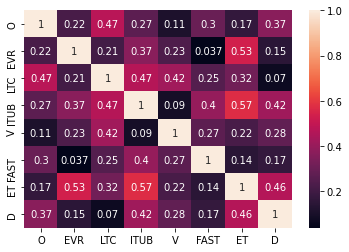

,Name,Industry,Sub-Industry,Risk,Exp.Ret,STD,Yield,Div Growth,Div.FREQ,Div.Month,S-Signal,M-Signal,L-Signal,S-Prob,M-Prob,L-Prob,S-Ret,M-Ret,L-Ret,S-Loss,M-Loss,L-Loss,LR WRet,LR R2,LR W Ret,Beta,CORR
O,Realty Income Corporation,Real Estate,REIT—Retail,0.295146,0.361953,0.155940,0.018048,0.008548,12,1,0.581011,0.596127,0.666509,0.626866,0.447761,0.462687,0.295970,0.077313,0.174925,-0.110000,-0.076000,-0.026250,0.0,0.550261,-0.013355,2.645108,1.000000
EVR,Evercore Inc.,Financial Services,Capital Markets,0.458930,0.089173,0.407959,0.011077,0.008690,4,2,0.538259,0.539578,0.542876,0.550000,0.600000,0.500000,0.568500,0.205000,0.064000,-0.047143,-0.358571,-0.087500,0.0,0.434961,0.053593,1.789201,0.219661
LTC,"LTC Properties, Inc.",Real Estate,REIT—Healthcare Facilities,0.329513,0.233475,0.298478,0.026700,-0.005634,12,1,0.534440,0.640664,0.622407,0.192308,0.384615,0.692308,-0.300769,0.477692,0.419615,-0.093750,-0.099091,-0.600000,0.0,0.548293,0.016254,2.492722,0.474913
ITUB,Itau Unibanco Holding S.A.,Financial Services,Banks—Regional,0.360203,0.198770,0.390382,0.061689,0.032226,12,1,0.534408,0.576565,0.530688,0.470588,0.352941,0.529412,0.132941,0.070882,0.193824,-0.118750,-0.137857,-0.124545,0.0,0.302675,-0.029154,1.906502,0.268032
V,Visa Inc.,Financial Services,Credit Services,0.106179,0.856282,0.172318,0.003167,0.008634,4,2,0.000000,0.000000,0.000000,0.510638,0.531915,0.914894,0.633404,0.782128,1.642766,-0.034286,-0.020000,0.000000,0.0,0.369454,-0.000316,0.358536,0.110296
FAST,Fastenal Company,Industrials,Industrial Distribution,0.202051,0.429337,0.238040,0.012953,0.013616,4,1,0.597474,0.702316,0.782737,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.197828,0.008912,1.078266,0.297372
ET,Energy Transfer LP,Energy,Oil & Gas Midstream,0.422043,0.158916,0.436445,0.075287,0.015833,4,2,0.531228,0.467368,0.467368,0.411765,0.529412,0.470588,0.312353,0.194118,0.150588,-0.126000,-0.137500,-0.205000,0.0,0.468849,0.045826,1.440425,0.167452
D,"Dominion Energy, Inc.",Utilities,Utilities—Diversified,0.264149,0.329735,0.150244,0.011872,0.007517,4,3,-0.592853,-0.656337,-0.739876,0.185567,0.381443,0.639175,0.134742,0.176701,0.291134,-0.040000,-0.050000,-0.102083,0.0,0.325741,0.002215,0.861521,0.368725


In [0]:
divPort = pd.Series(portAssets + DiYselect).drop_duplicates().to_list()
divRet = raret[divPort]

sn.heatmap(divRet.corr(), annot=True)
plt.show();

assetsDF.loc[divPort]

## Growth Selection

In [0]:
mCov = rmret.cov()
mRisk = rmret[rmret<-0.03].count()/rmret.count()
upsideR = rmret[rmret<-0.03].std()/rmret.std()
rmret['PORT'] = rmret[portAssets].mean(axis=1)
diversificaitonR = rmret[rmret['PORT'] < -0.03].corr()['PORT'].drop('PORT')

portRisk = rmret['PORT'][rmret['PORT'] < -0.03].count()/rmret['PORT'].count()
portUpside = rmret['PORT'][rmret['PORT'] < -0.03].std()/rmret['PORT'].std()
rmret = rmret.drop('PORT', axis=1)

lessRisky = mRisk[mRisk < portRisk*1.5].sort_values().index.to_list()
moreUpside = upsideR[upsideR >= portUpside*0.5].sort_values(ascending=False).index.to_list()
diversified = diversificaitonR[diversificaitonR < diversificaitonR.median()].index.to_list()
universe = pd.Series(lessRisky + moreUpside + diversified).drop_duplicates().to_list()

growSelect = []
pUpside = 0.0
pMu = 0.0
pRisk = 1.0

for i in range(len(prices.columns)*3):
    choice = list(np.random.choice(prices.columns.to_list(), size=3))
    
    if assetsDF.loc[choice, 'Industry'].drop_duplicates().count() == 3:
        
        if mret[choice].mean().min() > 0.0:
            
            pRet = mret[choice].mean(axis=1).dropna()    
            upside = 1 - pRet[pRet < -0.07].std()/pRet.std()
            risk = pRet[pRet < -0.07].count()/pRet.count()

            mu = 0.0
            for n in range(101):
                mu += pRet.quantile(n/100) * 0.01 * 12
            
            if mu > pMu and upside > pUpside:
                growSelect = choice[:]
                pMu = mu
                pUpside = upside
                pRisk = risk

                print(choice, mu, risk, upside)

print('\nMini-Portfolio Expected Return: {}%'.format(100*round(pMu,4)))
print('Mini-Portfolio upside potential: {}%'.format(100*round(pUpside,4)))
print('Mini-Portfolio Risk: {}%'.format(100*round(pRisk,4)))

['SPGI', 'EA', 'CHRW'] 0.13846794168382348 0.1128747795414462 0.29457742952336785
['BLK', 'TEL', 'PM'] 0.14951205492382896 0.10931174089068826 0.29567160918071866
['VRTX', 'MPC', 'NVDA'] 0.16938220480878946 0.24277456647398843 0.3570360499233226
['IEP', 'MSFT', 'V'] 0.17905399590288218 0.11219512195121951 0.4440884138076212

Mini-Portfolio Expected Return: 17.91%
Mini-Portfolio upside potential: 44.41%
Mini-Portfolio Risk: 11.219999999999999%


In [0]:
assetsDF.loc[growSelect]

,Name,Industry,Sub-Industry,Risk,Exp.Ret,STD,Yield,Div Growth,Div.FREQ,Div.Month,S-Signal,M-Signal,L-Signal,S-Prob,M-Prob,L-Prob,S-Ret,M-Ret,L-Ret,S-Loss,M-Loss,L-Loss,LR WRet,LR R2,LR W Ret,Beta,CORR
IEP,Icahn Enterprises L.P.,Industrials,Conglomerates,0.438917,0.054593,0.372503,0.081833,0.001667,4,3,0.473274,0.43931,0.481904,0.521739,0.565217,0.478261,0.140000,0.193043,0.113478,-0.081667,-0.100000,-0.172,0.0,0.349496,0.000012,2.117832,0.308414
MSFT,Microsoft Corporation,Technology,Software—Infrastructure,0.264291,0.299373,0.330554,0.005578,0.016057,4,2,0.000000,0.00000,0.000000,0.400000,0.500000,0.600000,-0.012000,0.035000,-1.180000,-0.136667,-0.116667,-0.100,0.0,0.313870,-0.009385,0.204133,0.043042
V,Visa Inc.,Financial Services,Credit Services,0.106179,0.856282,0.172318,0.003167,0.008634,4,2,0.000000,0.00000,0.000000,0.510638,0.531915,0.914894,0.633404,0.782128,1.642766,-0.034286,-0.020000,0.000,0.0,0.369454,-0.000316,0.358536,0.110296


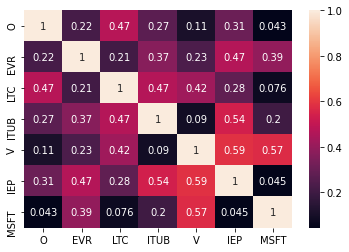

,Name,Industry,Sub-Industry,Risk,Exp.Ret,STD,Yield,Div Growth,Div.FREQ,Div.Month,S-Signal,M-Signal,L-Signal,S-Prob,M-Prob,L-Prob,S-Ret,M-Ret,L-Ret,S-Loss,M-Loss,L-Loss,LR WRet,LR R2,LR W Ret,Beta,CORR
O,Realty Income Corporation,Real Estate,REIT—Retail,0.295146,0.361953,0.155940,0.018048,0.008548,12,1,0.581011,0.596127,0.666509,0.626866,0.447761,0.462687,0.295970,0.077313,0.174925,-0.110000,-0.076000,-0.026250,0.0,0.550261,-0.013355,2.645108,1.000000
EVR,Evercore Inc.,Financial Services,Capital Markets,0.458930,0.089173,0.407959,0.011077,0.008690,4,2,0.538259,0.539578,0.542876,0.550000,0.600000,0.500000,0.568500,0.205000,0.064000,-0.047143,-0.358571,-0.087500,0.0,0.434961,0.053593,1.789201,0.219661
LTC,"LTC Properties, Inc.",Real Estate,REIT—Healthcare Facilities,0.329513,0.233475,0.298478,0.026700,-0.005634,12,1,0.534440,0.640664,0.622407,0.192308,0.384615,0.692308,-0.300769,0.477692,0.419615,-0.093750,-0.099091,-0.600000,0.0,0.548293,0.016254,2.492722,0.474913
ITUB,Itau Unibanco Holding S.A.,Financial Services,Banks—Regional,0.360203,0.198770,0.390382,0.061689,0.032226,12,1,0.534408,0.576565,0.530688,0.470588,0.352941,0.529412,0.132941,0.070882,0.193824,-0.118750,-0.137857,-0.124545,0.0,0.302675,-0.029154,1.906502,0.268032
V,Visa Inc.,Financial Services,Credit Services,0.106179,0.856282,0.172318,0.003167,0.008634,4,2,0.000000,0.000000,0.000000,0.510638,0.531915,0.914894,0.633404,0.782128,1.642766,-0.034286,-0.020000,0.000000,0.0,0.369454,-0.000316,0.358536,0.110296
IEP,Icahn Enterprises L.P.,Industrials,Conglomerates,0.438917,0.054593,0.372503,0.081833,0.001667,4,3,0.473274,0.439310,0.481904,0.521739,0.565217,0.478261,0.140000,0.193043,0.113478,-0.081667,-0.100000,-0.172000,0.0,0.349496,0.000012,2.117832,0.308414
MSFT,Microsoft Corporation,Technology,Software—Infrastructure,0.264291,0.299373,0.330554,0.005578,0.016057,4,2,0.000000,0.000000,0.000000,0.400000,0.500000,0.600000,-0.012000,0.035000,-1.180000,-0.136667,-0.116667,-0.100000,0.0,0.313870,-0.009385,0.204133,0.043042
V,Visa Inc.,Financial Services,Credit Services,0.106179,0.856282,0.172318,0.003167,0.008634,4,2,0.000000,0.000000,0.000000,0.510638,0.531915,0.914894,0.633404,0.782128,1.642766,-0.034286,-0.020000,0.000000,0.0,0.369454,-0.000316,0.358536,0.110296


In [0]:
growPort = pd.Series(portAssets + growSelect).drop_duplicates().to_list()
growRet = raret[growPort]

sn.heatmap(growRet.corr(), annot=True)
plt.show();

assetsDF.loc[portAssets + growSelect]

## High probability picks

In [0]:
hp = assetsDF[assetsDF['L-Prob']>=0.50].copy()
hp = hp[np.logical_and(hp['Exp.Ret']>0.0, hp['Yield']>0.0)]
ihp = pd.DataFrame()
hpp = []

for ind in assetsDF['Industry'].drop_duplicates().sort_values():
    if not ind in assetsDF.loc[portAssets, 'Industry']:
        ihp = hp[np.logical_and(hp['Industry']==ind, 
                                hp['S-Prob']>hp['S-Prob'].quantile(0.5))]
        ihp = ihp[ihp['M-Prob']>=ihp['M-Prob'].quantile(0.5)]
        hpp += ihp.index.to_list()

ihp = assetsDF.loc[hpp]
ihp['MinProb'] = ihp[['S-Signal','M-Signal','L-Signal']].min(axis=1)
ihp = ihp[ihp[['S-Signal','M-Signal','L-Signal']].mean(axis=1)>0.60].sort_values(by='MinProb', ascending=False)

hpp = ihp.index.to_list()
assetsDF.loc[hpp]

,Name,Industry,Sub-Industry,Risk,Exp.Ret,STD,Yield,Div Growth,Div.FREQ,Div.Month,S-Signal,M-Signal,L-Signal,S-Prob,M-Prob,L-Prob,S-Ret,M-Ret,L-Ret,S-Loss,M-Loss,L-Loss,LR WRet,LR R2,LR W Ret,Beta,CORR
SHW,The Sherwin-Williams Company,Basic Materials,Specialty Chemicals,0.211476,0.460910,0.209316,0.004689,0.011720,4,2,0.660299,0.693937,0.748754,0.406632,0.671902,0.815009,0.254538,0.469686,0.554729,-0.043988,-0.054421,-0.081791,0.0,0.426665,-0.007236,1.479152,0.458735
ACN,Accenture plc,Technology,Information Technology Services,0.190731,0.556530,0.176045,0.008326,0.003894,1,4,0.650082,0.774878,0.793638,0.555556,0.666667,0.777778,1.375556,2.313333,0.248889,0.000000,0.000000,0.000000,0.0,0.365696,0.003020,0.925976,0.292432
APH,Amphenol Corporation,Technology,Electronic Components,0.253688,0.405219,0.328924,0.002784,0.012898,4,3,0.623565,0.675529,0.809668,0.500000,0.794118,0.794118,0.895294,0.657059,1.275294,-0.091667,-0.036667,-0.052500,0.0,0.392379,0.022708,0.744426,0.137167
RTX,Raytheon Technologies Corporation,Industrials,Aerospace & Defense,0.298987,0.289208,0.226817,0.015640,0.006136,4,2,0.609293,0.650762,0.771172,0.548295,0.588068,0.772727,0.363182,0.346932,0.437102,-0.051067,-0.060704,-0.080196,0.0,0.473633,0.008969,0.855019,0.252265
CTSH,Cognizant Technology Solutions Corporation,Technology,Information Technology Services,0.300740,0.259453,0.405123,0.008562,0.004947,4,2,0.606164,0.642857,0.620352,0.645161,0.580645,0.612903,0.349355,0.369677,0.790968,-0.053333,-0.136250,-0.221429,0.0,0.349711,0.036372,0.760981,0.107034
SAP,SAP SE,Technology,Software—Application,0.326174,0.188801,0.333572,0.014740,0.003667,1,5,0.600181,0.629127,0.686567,0.343384,0.562814,0.589615,0.222060,0.335812,0.283601,-0.071292,-0.081283,-0.167598,0.0,0.298930,0.016974,0.132159,0.023112
MCD,McDonald's Corporation,Consumer Cyclical,Restaurants,0.276114,0.310961,0.286229,0.006817,0.024050,4,2,0.594073,0.657808,0.669332,0.394737,0.631579,0.605263,0.192500,0.354474,0.179605,-0.081481,-0.138000,-0.236296,0.0,0.388495,-0.002508,0.059775,0.016680
GL,Globe Life Inc.,Financial Services,Insurance—Life,0.308025,0.254974,0.250642,0.004994,-0.001356,4,1,0.591363,0.632491,0.651586,0.361111,0.555556,0.666667,0.135000,0.651389,0.302222,-0.164615,-0.206154,-0.275714,0.0,0.462243,-0.020851,2.079573,0.507024
AFL,Aflac Incorporated,Financial Services,Insurance—Life,0.214213,0.373697,0.275030,0.016260,0.009177,4,2,0.590843,0.676235,0.821221,0.485714,0.542857,0.800000,0.415714,0.546857,1.275429,-0.190000,-0.162222,-0.265000,0.0,0.443023,-0.004352,1.403217,0.318130
CBSH,"Commerce Bancshares, Inc.",Financial Services,Banks—Regional,0.266558,0.334694,0.162839,0.004532,0.000696,4,3,0.587654,0.665268,0.687743,0.340000,0.680000,0.820000,0.599400,0.857000,1.275400,-0.026667,-0.080000,-0.097500,0.0,0.310835,0.030004,0.724714,0.279934


# Asset allocation

## Macro allocation



## Micro allocation

# Rebalancing
